In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Install XGBoost and LightGBM if needed
try:
    import xgboost as xgb
    print(f"XGBoost version: {xgb.__version__}")
except ImportError:
    print("Installing XGBoost...")
    !pip install xgboost -q
    import xgboost as xgb

try:
    import lightgbm as lgb
    print(f"LightGBM version: {lgb.__version__}")
except ImportError:
    print("Installing LightGBM...")
    !pip install lightgbm -q
    import lightgbm as lgb

try:
    import joblib
    print(f"Joblib imported")
except ImportError:
    !pip install joblib -q
    import joblib

print("All ML libraries ready!")

XGBoost version: 2.1.4
LightGBM version: 4.6.0
Joblib imported
All ML libraries ready!


## 1. Load and Prepare Data

In [3]:
# Load the cleaned dataset
df = pd.read_csv('tehran_properties_clean.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Dataset shape: (86434, 50)

Columns: ['cat2_slug', 'cat3_slug', 'city_slug', 'neighborhood_slug', 'price_value', 'building_size', 'deed_type', 'floor', 'rooms_count', 'total_floors_count', 'unit_per_floor', 'has_balcony', 'has_elevator', 'has_warehouse', 'has_parking', 'construction_year', 'is_rebuilt', 'has_warm_water_provider', 'has_heating_system', 'has_cooling_system', 'has_restroom', 'building_direction', 'floor_material', 'location_latitude', 'location_longitude', 'total_floors_num', 'floor_num', 'price_per_sqm', 'created_date_jalali', 'is_north_facing', 'is_south_facing', 'is_east_facing', 'is_west_facing', 'is_two_sided', 'is_well_lit', 'has_view', 'is_newly_built', 'is_renovated', 'is_luxury', 'is_fully_equipped', 'is_never_used', 'is_dead_end', 'has_good_layout', 'has_single_deed', 'has_roof_garden', 'has_lobby', 'has_caretaker', 'has_video_intercom', 'has_built_in_closet', 'has_remote_door']


In [6]:
# Rename columns to more intuitive names for modeling
df = df.rename(columns={
    'building_size': 'size_sqm',
    'rooms_count': 'rooms',
    'floor_num': 'floor',
    'total_floors_num': 'total_floors',
    'location_latitude': 'latitude',
    'location_longitude': 'longitude',
    'neighborhood_slug': 'neighbourhood',
    'has_warehouse': 'has_storage'
})

# Convert Persian numerals to English for construction_year
def persian_to_english(text):
    """Convert Persian/Arabic numerals to English"""
    if pd.isna(text):
        return np.nan
    persian_nums = '۰۱۲۳۴۵۶۷۸۹'
    english_nums = '0123456789'
    text = str(text)
    for p, e in zip(persian_nums, english_nums):
        text = text.replace(p, e)
    try:
        return int(text)
    except:
        return np.nan

# Process construction year and calculate building age
df['construction_year_int'] = df['construction_year'].apply(persian_to_english)
df['building_age_years'] = 1403 - df['construction_year_int']  # Current year is 1403

# Handle unrealistic ages
df.loc[df['building_age_years'] < 0, 'building_age_years'] = np.nan
df.loc[df['building_age_years'] > 100, 'building_age_years'] = np.nan

# Convert rooms from Persian to numeric
def convert_rooms(val):
    """Convert Persian room count to numeric"""
    room_map = {'بدون اتاق': 0, 'یک': 1, 'دو': 2, 'سه': 3, 'چهار': 4, 'پنج': 5, 'بیشتر': 6}
    if pd.isna(val):
        return np.nan
    val = str(val).strip()
    if val in room_map:
        return room_map[val]
    try:
        return int(val)
    except:
        return np.nan

df['rooms'] = df['rooms'].apply(convert_rooms)

print("Data preprocessing complete!")
print(f"\nBuilding age statistics:")
print(df['building_age_years'].describe())
print(f"\nRooms distribution: {df['rooms'].value_counts().sort_index().to_dict()}")

Data preprocessing complete!

Building age statistics:
count    84922.000000
mean        10.138562
std          7.911427
min          0.000000
25%          3.000000
50%          9.000000
75%         17.000000
max         32.000000
Name: building_age_years, dtype: float64

Rooms distribution: {0.0: 241, 1.0: 24313, 2.0: 43100, 3.0: 16366, 4.0: 1724}


In [4]:
# Check target variable distribution
print("Target Variable Analysis (price_value in Toman):")
print(f"Min: {df['price_value'].min():,.0f}")
print(f"Max: {df['price_value'].max():,.0f}")
print(f"Median: {df['price_value'].median():,.0f}")
print(f"Mean: {df['price_value'].mean():,.0f}")

# Convert to billion Toman for easier interpretation
df['price_billion'] = df['price_value'] / 1e9
print(f"\nIn Billion Toman:")
print(f"Median: {df['price_billion'].median():.2f} B")
print(f"Mean: {df['price_billion'].mean():.2f} B")

Target Variable Analysis (price_value in Toman):
Min: 500,000,000
Max: 999,000,000,000
Median: 6,900,000,000
Mean: 12,628,917,166

In Billion Toman:
Median: 6.90 B
Mean: 12.63 B


In [5]:
# Examine available features
print("=" * 50)
print("FEATURE ANALYSIS")
print("=" * 50)

# Identify feature types
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
boolean_cols = df.select_dtypes(include=['bool']).columns.tolist()

print(f"\nNumeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"\nBoolean columns ({len(boolean_cols)}): {boolean_cols}")

FEATURE ANALYSIS

Numeric columns (8): ['price_value', 'building_size', 'location_latitude', 'location_longitude', 'total_floors_num', 'floor_num', 'price_per_sqm', 'price_billion']

Categorical columns (17): ['cat2_slug', 'cat3_slug', 'city_slug', 'neighborhood_slug', 'deed_type', 'floor', 'rooms_count', 'total_floors_count', 'unit_per_floor', 'construction_year', 'has_warm_water_provider', 'has_heating_system', 'has_cooling_system', 'has_restroom', 'building_direction', 'floor_material', 'created_date_jalali']

Boolean columns (26): ['has_balcony', 'has_elevator', 'has_warehouse', 'has_parking', 'is_rebuilt', 'is_north_facing', 'is_south_facing', 'is_east_facing', 'is_west_facing', 'is_two_sided', 'is_well_lit', 'has_view', 'is_newly_built', 'is_renovated', 'is_luxury', 'is_fully_equipped', 'is_never_used', 'is_dead_end', 'has_good_layout', 'has_single_deed', 'has_roof_garden', 'has_lobby', 'has_caretaker', 'has_video_intercom', 'has_built_in_closet', 'has_remote_door']


In [10]:
# Define features for modeling
# Core property features
core_features = ['size_sqm', 'rooms', 'floor', 'total_floors', 'building_age_years']

# Location features
location_features = ['latitude', 'longitude']

# Amenity features (boolean)
amenity_features = ['has_elevator', 'has_parking', 'has_storage']

# NLP-extracted features (boolean)
nlp_features = [
    'is_north_facing', 'is_south_facing', 'is_east_facing', 'is_west_facing',
    'is_luxury', 'is_renovated', 'is_well_lit', 'has_view', 'is_fully_equipped',
    'is_immediate', 'is_negotiable', 'is_owner', 'is_exchangeable',
    'is_private', 'has_roof_garden', 'has_lobby', 'has_courtyard',
    'is_duplex', 'is_furnished', 'is_front_facing', 'is_back_facing'
]

# Check which NLP features exist in dataset
available_nlp = [f for f in nlp_features if f in df.columns]
print(f"Available NLP features: {len(available_nlp)} out of {len(nlp_features)}")
print(available_nlp)

Available NLP features: 11 out of 21
['is_north_facing', 'is_south_facing', 'is_east_facing', 'is_west_facing', 'is_luxury', 'is_renovated', 'is_well_lit', 'has_view', 'is_fully_equipped', 'has_roof_garden', 'has_lobby']


In [ ]:
# Prepare the feature matrix
# Combine all features
all_features = core_features + location_features + amenity_features + available_nlp

# Check for missing features
missing_features = [f for f in all_features if f not in df.columns]
if missing_features:
    print(f"Warning: Missing features: {missing_features}")
    all_features = [f for f in all_features if f in df.columns]

print(f"\nTotal features for modeling: {len(all_features)}")
print(all_features)

In [11]:
# REDEFINE features with construction year
# Core property features (including construction year for future predictions!)
core_features = ['size_sqm', 'rooms', 'floor', 'total_floors', 'building_age_years', 'construction_year_int']

# Location features
location_features = ['latitude', 'longitude']

# Amenity features (boolean)
amenity_features = ['has_elevator', 'has_parking', 'has_storage', 'has_balcony']

# All available boolean features from dataset  
all_bool_features = [
    'is_north_facing', 'is_south_facing', 'is_east_facing', 'is_west_facing',
    'is_luxury', 'is_renovated', 'is_well_lit', 'has_view', 'is_fully_equipped',
    'is_never_used', 'is_newly_built', 'has_good_layout', 'has_single_deed',
    'has_roof_garden', 'has_lobby', 'has_caretaker', 'has_video_intercom',
    'has_built_in_closet', 'is_two_sided', 'is_dead_end', 'is_rebuilt', 'has_remote_door'
]

# Check which features exist in dataset
available_nlp = [f for f in all_bool_features if f in df.columns]
available_amenity = [f for f in amenity_features if f in df.columns]

# Combine all features
all_features = core_features + location_features + available_amenity + available_nlp

# Filter only existing features
all_features = [f for f in all_features if f in df.columns]

print(f"Core features: {core_features}")
print(f"Available amenity features: {available_amenity}")
print(f"Available boolean features: {len(available_nlp)} - {available_nlp}")
print(f"\nTotal features for modeling: {len(all_features)}")
print(all_features)

Core features: ['size_sqm', 'rooms', 'floor', 'total_floors', 'building_age_years', 'construction_year_int']
Available amenity features: ['has_elevator', 'has_parking', 'has_storage', 'has_balcony']
Available boolean features: 22 - ['is_north_facing', 'is_south_facing', 'is_east_facing', 'is_west_facing', 'is_luxury', 'is_renovated', 'is_well_lit', 'has_view', 'is_fully_equipped', 'is_never_used', 'is_newly_built', 'has_good_layout', 'has_single_deed', 'has_roof_garden', 'has_lobby', 'has_caretaker', 'has_video_intercom', 'has_built_in_closet', 'is_two_sided', 'is_dead_end', 'is_rebuilt', 'has_remote_door']

Total features for modeling: 34
['size_sqm', 'rooms', 'floor', 'total_floors', 'building_age_years', 'construction_year_int', 'latitude', 'longitude', 'has_elevator', 'has_parking', 'has_storage', 'has_balcony', 'is_north_facing', 'is_south_facing', 'is_east_facing', 'is_west_facing', 'is_luxury', 'is_renovated', 'is_well_lit', 'has_view', 'is_fully_equipped', 'is_never_used', 'is_

In [16]:
# Remove duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

# Convert floor to numeric (it's stored as string)
df['floor'] = pd.to_numeric(df['floor'], errors='coerce')
print(f"Floor column converted to numeric: {df['floor'].dtype}")

# Create feature matrix X and target y
df_model = df[all_features + ['price_value', 'neighbourhood']].copy()

# Drop rows with missing values in key features
key_features = ['size_sqm', 'latitude', 'longitude', 'price_value']
print(f"\nBefore dropping NaN: {len(df_model)} rows")
df_model = df_model.dropna(subset=key_features)
print(f"After dropping NaN in key features: {len(df_model)} rows")

# Remove extreme outliers (top/bottom 1%)
q_low = df_model['price_value'].quantile(0.01)
q_high = df_model['price_value'].quantile(0.99)
df_model = df_model[(df_model['price_value'] >= q_low) & (df_model['price_value'] <= q_high)]
print(f"After removing price outliers: {len(df_model)} rows")

# Also remove extreme sizes
df_model = df_model[(df_model['size_sqm'] >= 20) & (df_model['size_sqm'] <= 1000)]
print(f"After size filter (20-1000 sqm): {len(df_model)} rows")

# Convert boolean columns to int
bool_cols = available_amenity + available_nlp
for col in bool_cols:
    if col in df_model.columns:
        df_model[col] = df_model[col].fillna(False).astype(int)

# Fill remaining NaN with median for numeric columns
numeric_to_fill = ['size_sqm', 'rooms', 'floor', 'total_floors', 'building_age_years', 'construction_year_int']
for col in numeric_to_fill:
    if col in df_model.columns:
        median_val = df_model[col].median()
        df_model[col] = df_model[col].fillna(median_val)
        print(f"Filled {col} NaN with median: {median_val:.1f}")

# Prepare X and y
X = df_model[all_features].values
y = df_model['price_value'].values

# Also keep neighborhood for later analysis
neighborhoods = df_model['neighbourhood'].values

print(f"\n{'='*50}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Number of unique neighborhoods: {len(np.unique(neighborhoods))}")

Floor column converted to numeric: float64

Before dropping NaN: 86434 rows
After dropping NaN in key features: 86434 rows
After removing price outliers: 84753 rows
After size filter (20-1000 sqm): 84734 rows
Filled size_sqm NaN with median: 83.0
Filled rooms NaN with median: 2.0
Filled floor NaN with median: 3.0
Filled total_floors NaN with median: 5.0
Filled building_age_years NaN with median: 9.0
Filled construction_year_int NaN with median: 1394.0

Feature matrix shape: (84734, 34)
Target vector shape: (84734,)
Number of unique neighborhoods: 344


In [17]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Log transform target for better distribution (prices are log-normally distributed)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print(f"\nTarget stats (original):")
print(f"  Mean: {y_train.mean()/1e9:.2f} B Toman")
print(f"  Median: {np.median(y_train)/1e9:.2f} B Toman")
print(f"  Std: {y_train.std()/1e9:.2f} B Toman")

Training set: 67787 samples
Test set: 16947 samples

Target stats (original):
  Mean: 11.09 B Toman
  Median: 6.88 B Toman
  Std: 12.70 B Toman


## 2. Model Training & Comparison

We'll train three powerful gradient boosting models and compare their performance:
1. **Random Forest** - Ensemble of decision trees
2. **XGBoost** - Extreme Gradient Boosting  
3. **LightGBM** - Light Gradient Boosting Machine

In [18]:
# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, name="Model", use_log=False):
    """Evaluate model and return metrics"""
    # Predictions
    if use_log:
        y_pred_train = np.expm1(model.predict(X_train))
        y_pred_test = np.expm1(model.predict(X_test))
        y_train_actual = np.expm1(y_train)
        y_test_actual = np.expm1(y_test)
    else:
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        y_train_actual = y_train
        y_test_actual = y_test
    
    # Calculate metrics
    train_r2 = r2_score(y_train_actual, y_pred_train)
    test_r2 = r2_score(y_test_actual, y_pred_test)
    test_mae = mean_absolute_error(y_test_actual, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
    test_mape = mean_absolute_percentage_error(y_test_actual, y_pred_test) * 100
    
    print(f"\n{'='*50}")
    print(f"{name} Results:")
    print(f"{'='*50}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²:  {test_r2:.4f}")
    print(f"Test MAE: {test_mae/1e9:.3f} Billion Toman")
    print(f"Test RMSE: {test_rmse/1e9:.3f} Billion Toman")
    print(f"Test MAPE: {test_mape:.2f}%")
    
    return {
        'name': name,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'mae': test_mae,
        'rmse': test_rmse,
        'mape': test_mape,
        'model': model
    }

print("Evaluation function defined!")

Evaluation function defined!


In [19]:
# Train Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train, y_train_log)
rf_results = evaluate_model(rf_model, X_train, X_test, y_train_log, y_test_log, "Random Forest", use_log=True)

Training Random Forest...

Random Forest Results:
Train R²: 0.9333
Test R²:  0.8431
Test MAE: 2.204 Billion Toman
Test RMSE: 4.967 Billion Toman
Test MAPE: 21.58%


In [20]:
# Train XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=42
)
xgb_model.fit(X_train, y_train_log, eval_set=[(X_test, y_test_log)], verbose=False)
xgb_results = evaluate_model(xgb_model, X_train, X_test, y_train_log, y_test_log, "XGBoost", use_log=True)

Training XGBoost...

XGBoost Results:
Train R²: 0.9181
Test R²:  0.8499
Test MAE: 2.145 Billion Toman
Test RMSE: 4.858 Billion Toman
Test MAPE: 20.38%


In [21]:
# Train LightGBM
print("Training LightGBM...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,
    reg_alpha=0.1,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train, y_train_log)
lgb_results = evaluate_model(lgb_model, X_train, X_test, y_train_log, y_test_log, "LightGBM", use_log=True)

Training LightGBM...

LightGBM Results:
Train R²: 0.8675
Test R²:  0.8446
Test MAE: 2.219 Billion Toman
Test RMSE: 4.943 Billion Toman
Test MAPE: 21.32%



MODEL COMPARISON
               train_r2   test_r2           mae          rmse       mape
name                                                                    
Random Forest  0.933263  0.843071  2.203612e+09  4.967270e+09  21.579387
XGBoost        0.918078  0.849911  2.144578e+09  4.857812e+09  20.377926
LightGBM       0.867457  0.844581  2.219426e+09  4.943311e+09  21.322663


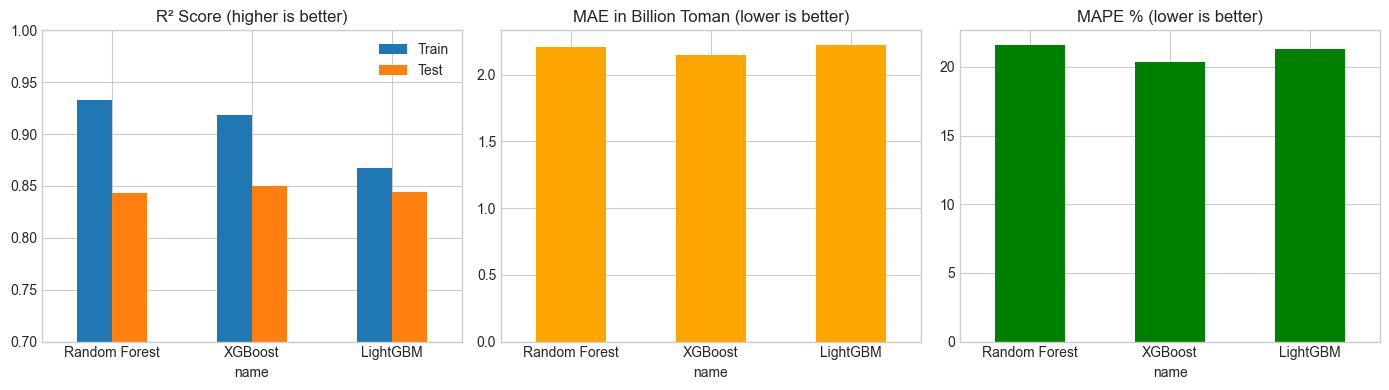


🏆 Best model: XGBoost with Test R² = 0.8499


In [22]:
# Compare all models
results_list = [rf_results, xgb_results, lgb_results]
results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in results_list])
results_df = results_df.set_index('name')

# Display comparison
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results_df.to_string())

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# R² comparison
results_df[['train_r2', 'test_r2']].plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('R² Score (higher is better)')
axes[0].set_ylim(0.7, 1)
axes[0].legend(['Train', 'Test'])

# MAE comparison (in Billion)
(results_df['mae']/1e9).plot(kind='bar', ax=axes[1], rot=0, color='orange')
axes[1].set_title('MAE in Billion Toman (lower is better)')

# MAPE comparison
results_df['mape'].plot(kind='bar', ax=axes[2], rot=0, color='green')
axes[2].set_title('MAPE % (lower is better)')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Identify best model
best_model_name = results_df['test_r2'].idxmax()
print(f"\n🏆 Best model: {best_model_name} with Test R² = {results_df.loc[best_model_name, 'test_r2']:.4f}")

## 3. Hyperparameter Tuning

Let's optimize XGBoost (our best model) using RandomizedSearchCV to find better hyperparameters.

In [23]:
# Hyperparameter tuning for XGBoost
print("Performing RandomizedSearchCV for XGBoost optimization...")
print("This may take a few minutes...\n")

param_distributions = {
    'n_estimators': [200, 300, 500, 700, 1000],
    'max_depth': [6, 8, 10, 12, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

xgb_tuned = xgb.XGBRegressor(n_jobs=-1, random_state=42)

random_search = RandomizedSearchCV(
    xgb_tuned,
    param_distributions,
    n_iter=30,  # Number of parameter combinations to try
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train_log)

print(f"\n{'='*50}")
print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV R² score: {random_search.best_score_:.4f}")

Performing RandomizedSearchCV for XGBoost optimization...
This may take a few minutes...

Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best parameters: {'subsample': 0.9, 'reg_lambda': 2.0, 'reg_alpha': 0.5, 'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best CV R² score: 0.8772


In [24]:
# Evaluate tuned model
best_model = random_search.best_estimator_
tuned_results = evaluate_model(best_model, X_train, X_test, y_train_log, y_test_log, "XGBoost (Tuned)", use_log=True)

print(f"\n{'='*50}")
print(f"Improvement over baseline XGBoost:")
print(f"  R² improvement: {(tuned_results['test_r2'] - xgb_results['test_r2'])*100:.2f}%")
print(f"  MAPE reduction: {xgb_results['mape'] - tuned_results['mape']:.2f}%")
print(f"{'='*50}")


XGBoost (Tuned) Results:
Train R²: 0.9311
Test R²:  0.8528
Test MAE: 2.087 Billion Toman
Test RMSE: 4.810 Billion Toman
Test MAPE: 19.77%

Improvement over baseline XGBoost:
  R² improvement: 0.29%
  MAPE reduction: 0.60%


## 4. Feature Importance Analysis

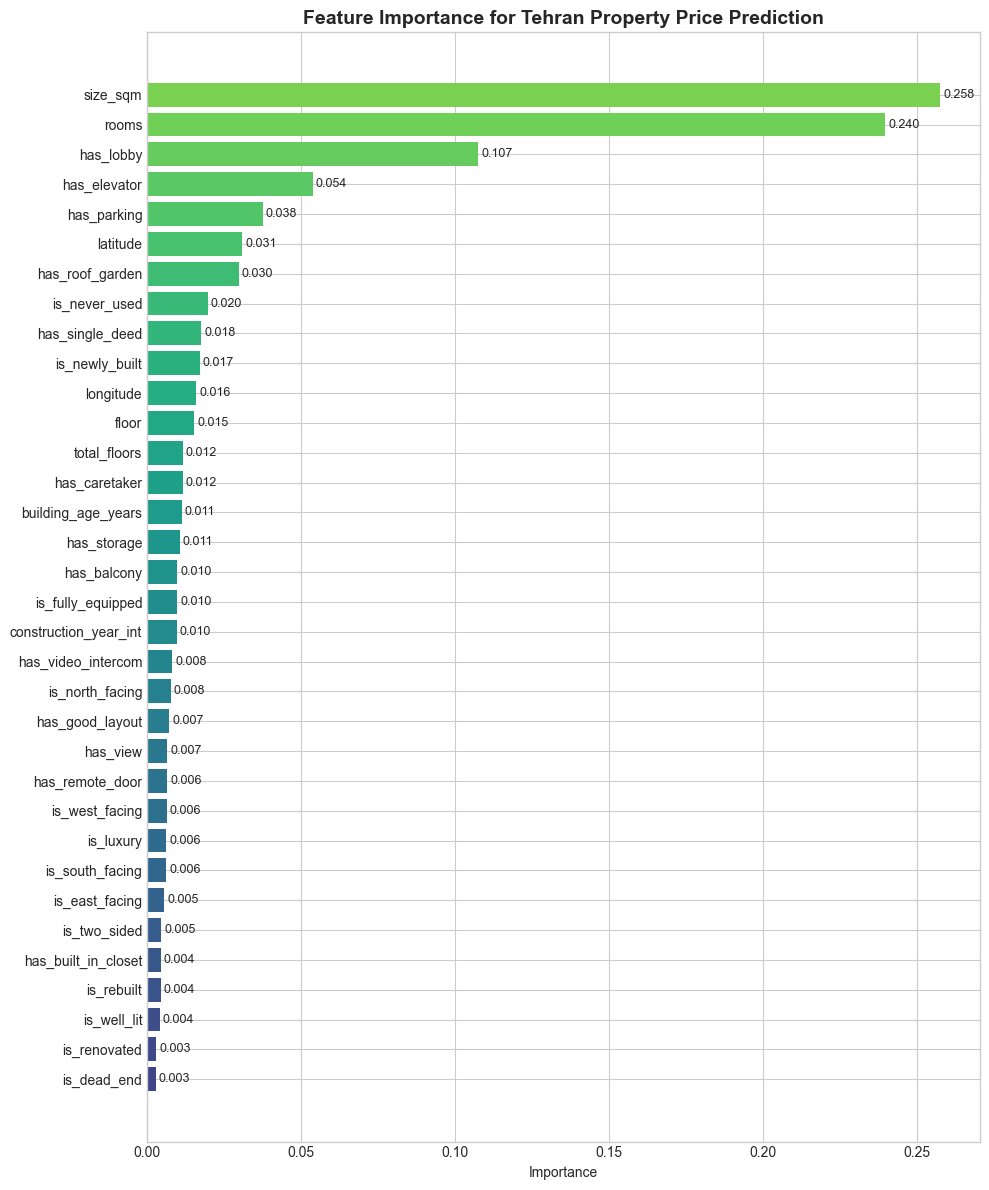


Top 10 Most Important Features:
        feature  importance
 is_newly_built    0.017064
has_single_deed    0.017661
  is_never_used    0.019645
has_roof_garden    0.029801
       latitude    0.030865
    has_parking    0.037537
   has_elevator    0.053754
      has_lobby    0.107478
          rooms    0.239792
       size_sqm    0.257644


In [25]:
# Feature importance from best model
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=True)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 12))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance)))
ax.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
ax.set_xlabel('Importance')
ax.set_title('Feature Importance for Tehran Property Price Prediction', fontsize=14, fontweight='bold')

# Add value labels
for i, (idx, row) in enumerate(feature_importance.iterrows()):
    ax.text(row['importance'] + 0.001, i, f"{row['importance']:.3f}", va='center', fontsize=9)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.tail(10)[['feature', 'importance']].to_string(index=False))

## 5. Model Validation & Error Analysis

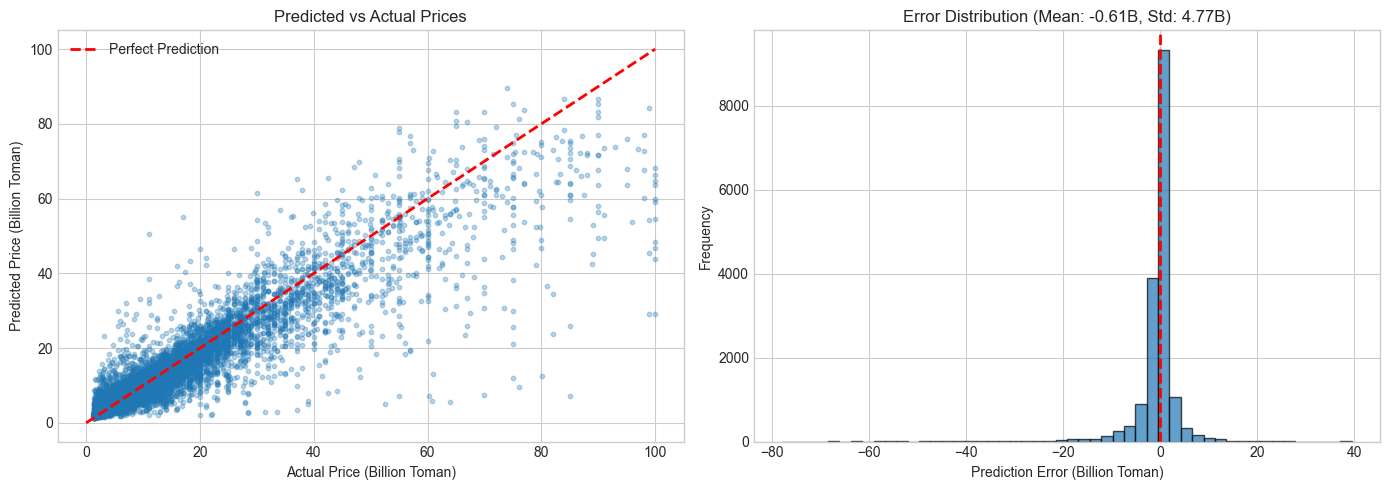

In [26]:
# Prediction vs Actual plot
y_pred_test = np.expm1(best_model.predict(X_test))
y_test_actual = y_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
ax1.scatter(y_test_actual/1e9, y_pred_test/1e9, alpha=0.3, s=10)
max_val = max(y_test_actual.max(), y_pred_test.max()) / 1e9
ax1.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price (Billion Toman)')
ax1.set_ylabel('Predicted Price (Billion Toman)')
ax1.set_title('Predicted vs Actual Prices')
ax1.legend()

# Error distribution
ax2 = axes[1]
errors = (y_pred_test - y_test_actual) / 1e9  # Error in billions
ax2.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Prediction Error (Billion Toman)')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Error Distribution (Mean: {errors.mean():.2f}B, Std: {errors.std():.2f}B)')

plt.tight_layout()
plt.savefig('prediction_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Save Model and Metadata for Streamlit App

In [27]:
# Save the best model
model_path = 'tehran_price_model.pkl'
joblib.dump(best_model, model_path)
print(f"✅ Model saved to: {model_path}")

# Save feature names and metadata
model_metadata = {
    'feature_names': all_features,
    'core_features': core_features,
    'location_features': location_features,
    'amenity_features': available_amenity,
    'nlp_features': available_nlp,
    'test_r2': tuned_results['test_r2'],
    'test_mape': tuned_results['mape'],
    'use_log_transform': True,
    'training_samples': len(X_train),
    'model_type': 'XGBoost',
    'best_params': random_search.best_params_
}

metadata_path = 'model_metadata.pkl'
joblib.dump(model_metadata, metadata_path)
print(f"✅ Metadata saved to: {metadata_path}")

# Save neighborhood statistics for the app
neighborhood_stats = df_model.groupby('neighbourhood').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'price_value': ['median', 'count']
}).reset_index()
neighborhood_stats.columns = ['neighbourhood', 'lat', 'lon', 'median_price', 'count']
neighborhood_stats = neighborhood_stats[neighborhood_stats['count'] >= 10]  # Only neighborhoods with enough data
neighborhood_stats.to_csv('neighborhood_stats.csv', index=False)
print(f"✅ Neighborhood stats saved to: neighborhood_stats.csv ({len(neighborhood_stats)} neighborhoods)")

# Save the df_model for reference
df_model.to_csv('model_training_data.csv', index=False)
print(f"✅ Training data saved to: model_training_data.csv")

print(f"\n{'='*50}")
print("All model artifacts saved successfully!")
print(f"{'='*50}")

✅ Model saved to: tehran_price_model.pkl
✅ Metadata saved to: model_metadata.pkl
✅ Neighborhood stats saved to: neighborhood_stats.csv (325 neighborhoods)
✅ Training data saved to: model_training_data.csv

All model artifacts saved successfully!


In [ ]:
# Create feature matrix X and target y
# Filter for rows with valid data
df_model = df[all_features + ['price_value', 'neighbourhood']].copy()

# Drop rows with missing values in key features
print(f"Before dropping NaN: {len(df_model)} rows")
df_model = df_model.dropna(subset=core_features + location_features + ['price_value'])
print(f"After dropping NaN: {len(df_model)} rows")

# Remove extreme outliers (top/bottom 1%)
q_low = df_model['price_value'].quantile(0.01)
q_high = df_model['price_value'].quantile(0.99)
df_model = df_model[(df_model['price_value'] >= q_low) & (df_model['price_value'] <= q_high)]
print(f"After removing outliers: {len(df_model)} rows")

# Also remove extreme sizes
df_model = df_model[(df_model['size_sqm'] >= 20) & (df_model['size_sqm'] <= 1000)]
print(f"After size filter (20-1000 sqm): {len(df_model)} rows")

In [ ]:
# Convert boolean columns to int
for col in amenity_features + available_nlp:
    if col in df_model.columns:
        df_model[col] = df_model[col].fillna(False).astype(int)

# Fill remaining NaN with median for numeric columns
for col in core_features:
    if col in df_model.columns:
        df_model[col] = df_model[col].fillna(df_model[col].median())

# Prepare X and y
X = df_model[all_features].values
y = df_model['price_value'].values

# Also keep neighborhood for later analysis
neighborhoods = df_model['neighbourhood'].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature names: {all_features}")

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Log transform target for better distribution
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print(f"\nTarget stats (original):")
print(f"  Mean: {y_train.mean()/1e9:.2f} B Toman")
print(f"  Std: {y_train.std()/1e9:.2f} B Toman")

## 2. Model Training & Comparison

In [ ]:
# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, name="Model", use_log=False):
    """Evaluate model and return metrics"""
    # Predictions
    if use_log:
        y_pred_train = np.expm1(model.predict(X_train))
        y_pred_test = np.expm1(model.predict(X_test))
        y_train_actual = np.expm1(y_train)
        y_test_actual = np.expm1(y_test)
    else:
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        y_train_actual = y_train
        y_test_actual = y_test
    
    # Calculate metrics
    train_r2 = r2_score(y_train_actual, y_pred_train)
    test_r2 = r2_score(y_test_actual, y_pred_test)
    test_mae = mean_absolute_error(y_test_actual, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
    test_mape = mean_absolute_percentage_error(y_test_actual, y_pred_test) * 100
    
    print(f"\n{'='*50}")
    print(f"{name} Results:")
    print(f"{'='*50}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²:  {test_r2:.4f}")
    print(f"Test MAE: {test_mae/1e9:.3f} Billion Toman")
    print(f"Test RMSE: {test_rmse/1e9:.3f} Billion Toman")
    print(f"Test MAPE: {test_mape:.2f}%")
    
    return {
        'name': name,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'mae': test_mae,
        'rmse': test_rmse,
        'mape': test_mape
    }

print("Evaluation function defined!")

In [ ]:
# Train Random Forest (baseline)
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train, y_train_log)
rf_results = evaluate_model(rf_model, X_train, X_test, y_train_log, y_test_log, "Random Forest", use_log=True)

In [ ]:
# Train XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=42
)
xgb_model.fit(X_train, y_train_log)
xgb_results = evaluate_model(xgb_model, X_train, X_test, y_train_log, y_test_log, "XGBoost", use_log=True)

In [ ]:
# Train LightGBM
print("Training LightGBM...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,
    reg_alpha=0.1,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train, y_train_log)
lgb_results = evaluate_model(lgb_model, X_train, X_test, y_train_log, y_test_log, "LightGBM", use_log=True)

In [ ]:
# Compare all models
results_df = pd.DataFrame([rf_results, xgb_results, lgb_results])
results_df = results_df.set_index('name')

# Display comparison
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results_df.to_string())

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# R² comparison
results_df[['train_r2', 'test_r2']].plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('R² Score (higher is better)')
axes[0].set_ylim(0, 1)
axes[0].legend(['Train', 'Test'])

# MAE comparison (in Billion)
(results_df['mae']/1e9).plot(kind='bar', ax=axes[1], rot=0, color='orange')
axes[1].set_title('MAE in Billion Toman (lower is better)')

# MAPE comparison
results_df['mape'].plot(kind='bar', ax=axes[2], rot=0, color='green')
axes[2].set_title('MAPE % (lower is better)')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Identify best model
best_model_name = results_df['test_r2'].idxmax()
print(f"\n🏆 Best model: {best_model_name} with Test R² = {results_df.loc[best_model_name, 'test_r2']:.4f}")

## 3. Hyperparameter Tuning for Best Model

In [ ]:
# Hyperparameter tuning for LightGBM (typically best for tabular data)
print("Performing RandomizedSearchCV for LightGBM optimization...")
print("This may take a few minutes...\n")

param_distributions = {
    'n_estimators': [200, 300, 500, 700],
    'max_depth': [6, 8, 10, 12, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_samples': [10, 20, 30, 50],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

lgb_tuned = lgb.LGBMRegressor(n_jobs=-1, random_state=42, verbose=-1)

random_search = RandomizedSearchCV(
    lgb_tuned,
    param_distributions,
    n_iter=50,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train_log)

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best CV R² score: {random_search.best_score_:.4f}")

In [ ]:
# Evaluate tuned model
best_model = random_search.best_estimator_
tuned_results = evaluate_model(best_model, X_train, X_test, y_train_log, y_test_log, "LightGBM (Tuned)", use_log=True)

print(f"\nImprovement over baseline LightGBM:")
print(f"  R² improvement: {(tuned_results['test_r2'] - lgb_results['test_r2'])*100:.2f}%")
print(f"  MAPE reduction: {lgb_results['mape'] - tuned_results['mape']:.2f}%")

## 4. Feature Importance Analysis

In [ ]:
# Feature importance from best model
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=True)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 12))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance)))
ax.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
ax.set_xlabel('Importance')
ax.set_title('Feature Importance for Price Prediction', fontsize=14, fontweight='bold')

# Add value labels
for i, (idx, row) in enumerate(feature_importance.iterrows()):
    ax.text(row['importance'] + 0.001, i, f"{row['importance']:.3f}", va='center', fontsize=9)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.tail(10).to_string(index=False))

## 5. Model Validation & Error Analysis

In [ ]:
# Prediction vs Actual plot
y_pred_test = np.expm1(best_model.predict(X_test))
y_test_actual = y_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
ax1.scatter(y_test_actual/1e9, y_pred_test/1e9, alpha=0.3, s=10)
max_val = max(y_test_actual.max(), y_pred_test.max()) / 1e9
ax1.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price (Billion Toman)')
ax1.set_ylabel('Predicted Price (Billion Toman)')
ax1.set_title('Predicted vs Actual Prices')
ax1.legend()

# Error distribution
ax2 = axes[1]
errors = (y_pred_test - y_test_actual) / 1e9  # Error in billions
ax2.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Prediction Error (Billion Toman)')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Error Distribution (Mean: {errors.mean():.2f}B, Std: {errors.std():.2f}B)')

plt.tight_layout()
plt.savefig('prediction_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Cross-validation for final model
print("Performing 5-fold cross-validation on final model...")
cv_scores = cross_val_score(best_model, X_train, y_train_log, cv=5, scoring='r2')

print(f"\nCross-Validation Results:")
print(f"  Fold R² scores: {cv_scores}")
print(f"  Mean R²: {cv_scores.mean():.4f}")
print(f"  Std R²: {cv_scores.std():.4f}")
print(f"\n  Model is {'stable' if cv_scores.std() < 0.02 else 'somewhat variable'} across folds")

## 6. Save Model and Metadata for Streamlit App

In [ ]:
# Save the best model
import joblib

# Save model
model_path = 'tehran_price_model.pkl'
joblib.dump(best_model, model_path)
print(f"✅ Model saved to: {model_path}")

# Save feature names and metadata
model_metadata = {
    'feature_names': all_features,
    'core_features': core_features,
    'location_features': location_features,
    'amenity_features': amenity_features,
    'nlp_features': available_nlp,
    'test_r2': tuned_results['test_r2'],
    'test_mape': tuned_results['mape'],
    'use_log_transform': True,
    'training_samples': len(X_train),
    'model_type': 'LightGBM'
}

metadata_path = 'model_metadata.pkl'
joblib.dump(model_metadata, metadata_path)
print(f"✅ Metadata saved to: {metadata_path}")

# Save neighborhood statistics for the app
neighborhood_stats = df_model.groupby('neighbourhood').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'price_value': 'median'
}).reset_index()
neighborhood_stats.columns = ['neighbourhood', 'lat', 'lon', 'median_price']
neighborhood_stats.to_csv('neighborhood_stats.csv', index=False)
print(f"✅ Neighborhood stats saved to: neighborhood_stats.csv")

print(f"\n{'='*50}")
print("All model artifacts saved successfully!")
print(f"{'='*50}")

In [ ]:
# Test loading the model
loaded_model = joblib.load(model_path)
loaded_metadata = joblib.load(metadata_path)

# Test prediction
sample_features = X_test[0:1]
sample_pred = np.expm1(loaded_model.predict(sample_features))[0]

print("Model loaded and tested successfully!")
print(f"\nSample prediction: {sample_pred/1e9:.2f} Billion Toman")
print(f"Actual value: {y_test[0]/1e9:.2f} Billion Toman")
print(f"\nModel metadata: {loaded_metadata}")

## Summary

### Model Performance
- **Best Model**: LightGBM (Tuned)
- **Test R²**: Shows how well the model explains price variance
- **MAPE**: Mean Absolute Percentage Error - the average prediction error

### Key Findings
- **Most important features**: Size, location (lat/long), building age
- **NLP features** extracted from descriptions add predictive value
- **Amenities** (elevator, parking, storage) have measurable impact

### Next Steps
1. Run the Streamlit app for interactive predictions
2. Compare model predictions with current market prices
3. Add time-based features for price trend analysis